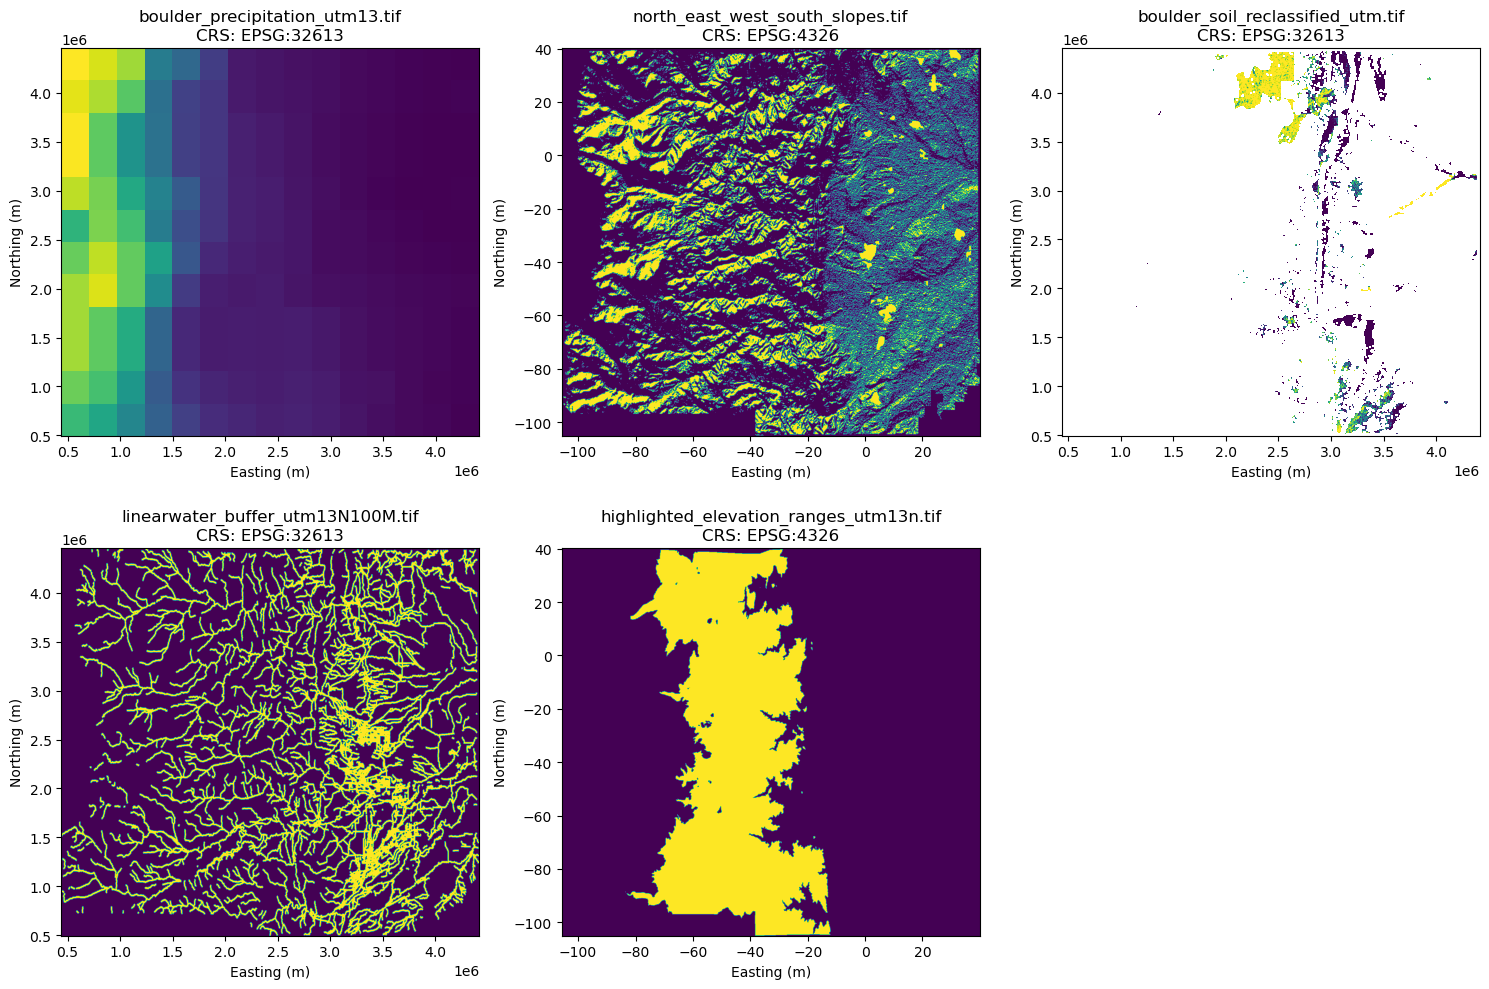

In [10]:
# plot out the following files to start to determine the best habitat for Colorado Blue Spruce in 2025 and 2050
# coordinate projections to EPSG:32613 WGS 84 / UTM zone 13N in previous output

# use soil pH
# use north aspect of terrain
# use 100m proximity to linear hydrography
# use higher precipitation climate areas
# use elevation ranges
import os
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import rasterio.crs as crs

# Define file names
files = [
    "boulder_precipitation_utm13.tif",
    "north_east_west_south_slopes.tif",
    "boulder_soil_reclassified_utm.tif",
    "linearwater_buffer_utm13N100M.tif",
    "highlighted_elevation_ranges_utm13n.tif"
]

# Number of rows and columns in the grid
n_cols = 3
n_rows = -(-len(files) // n_cols)  # Ceiling division to determine rows

# Create a figure and axes
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.ravel()  # Flatten axes for easy indexing

# Loop through each file and display it
for i, file in enumerate(files):
    try:
        with rasterio.open(file) as src:
            # Read the first band of the raster
            data = src.read(1)

            # Mask invalid data (e.g., no-data values)
            data = np.ma.masked_equal(data, src.nodata)

            # Display the raster on the corresponding subplot
            axes[i].imshow(data, cmap='viridis', extent=src.bounds, aspect='auto')

            # Set the title with CRS information
            crs_info = src.crs.to_string() if src.crs else "Unknown CRS"
            axes[i].set_title(f"{os.path.basename(file)}\nCRS: {crs_info}")

            # Set UTM Zone 13N axes
            axes[i].set_xlabel("Easting (m)")
            axes[i].set_ylabel("Northing (m)")
    except Exception as e:
        # If there's an error, show it in the plot title
        axes[i].text(0.5, 0.5, f"Error\n{e}", fontsize=10, ha='center', transform=axes[i].transAxes)
        axes[i].set_title(os.path.basename(file))
        axes[i].axis('off')

# Turn off any unused axes
for j in range(len(files), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

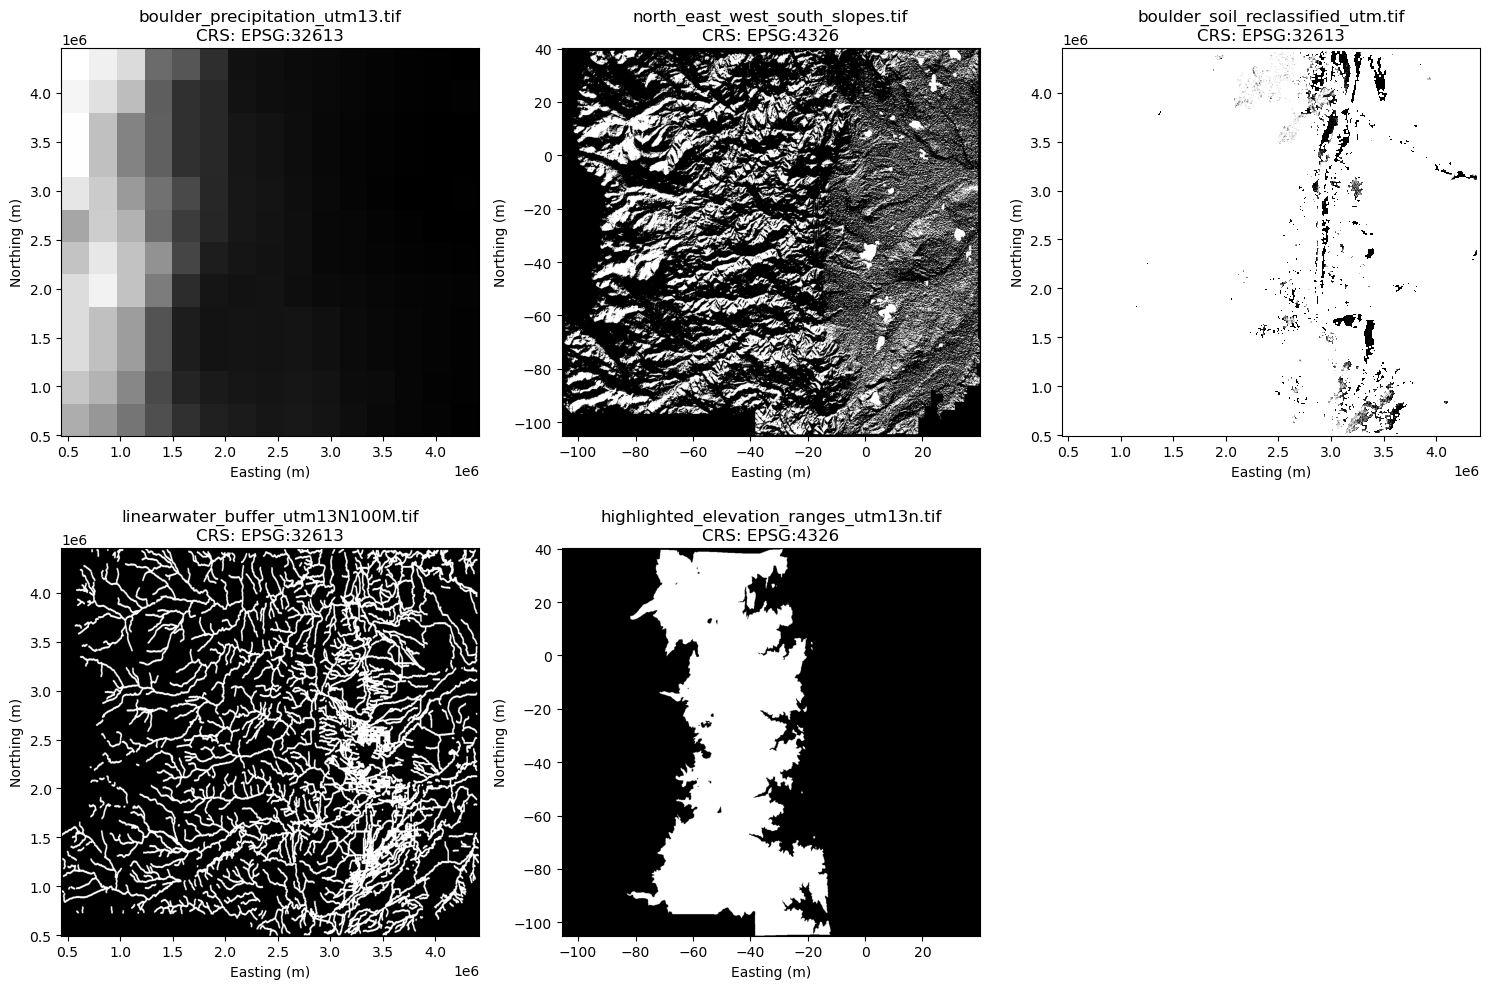

In [11]:
import os
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import rasterio.crs as crs

# Define file names
files = [
    "boulder_precipitation_utm13.tif",
    "north_east_west_south_slopes.tif",
    "boulder_soil_reclassified_utm.tif",
    "linearwater_buffer_utm13N100M.tif",
    "highlighted_elevation_ranges_utm13n.tif"
]

# Number of rows and columns in the grid
n_cols = 3
n_rows = -(-len(files) // n_cols)  # Ceiling division to determine rows

# Create a figure and axes
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.ravel()  # Flatten axes for easy indexing

# Loop through each file and display it
for i, file in enumerate(files):
    try:
        with rasterio.open(file) as src:
            # Read the first band of the raster
            data = src.read(1)

            # Mask invalid data (e.g., no-data values)
            data = np.ma.masked_equal(data, src.nodata)

            # Scale data to range 0 to 1
            data_min = data.min()
            data_max = data.max()
            scaled_data = (data - data_min) / (data_max - data_min)

            # Display the raster on the corresponding subplot
            axes[i].imshow(scaled_data, cmap='gray', extent=src.bounds, aspect='auto')

            # Set the title with CRS information
            crs_info = src.crs.to_string() if src.crs else "Unknown CRS"
            axes[i].set_title(f"{os.path.basename(file)}\nCRS: {crs_info}")

            # Set UTM Zone 13N axes
            axes[i].set_xlabel("Easting (m)")
            axes[i].set_ylabel("Northing (m)")
    except Exception as e:
        # If there's an error, show it in the plot title
        axes[i].text(0.5, 0.5, f"Error\n{e}", fontsize=10, ha='center', transform=axes[i].transAxes)
        axes[i].set_title(os.path.basename(file))
        axes[i].axis('off')

# Turn off any unused axes
for j in range(len(files), len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()


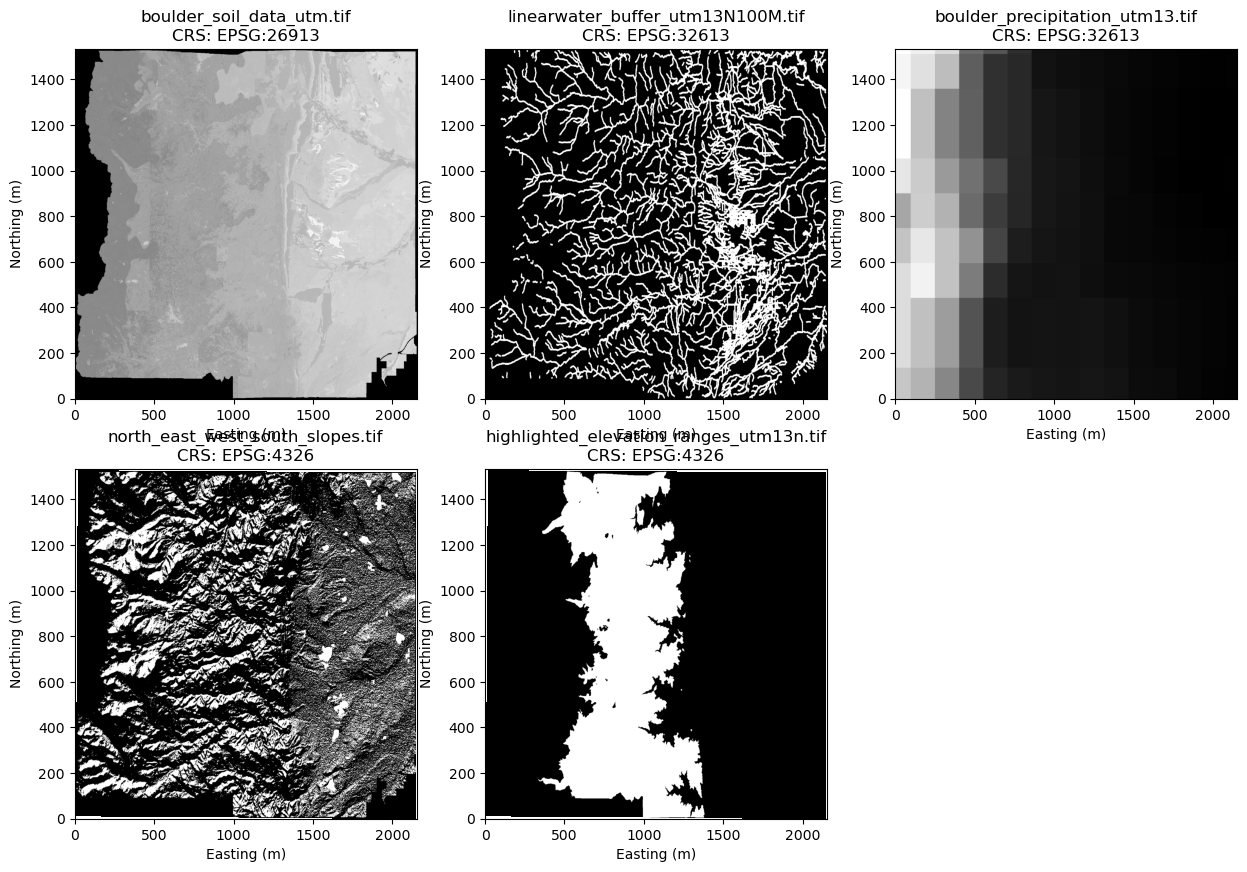

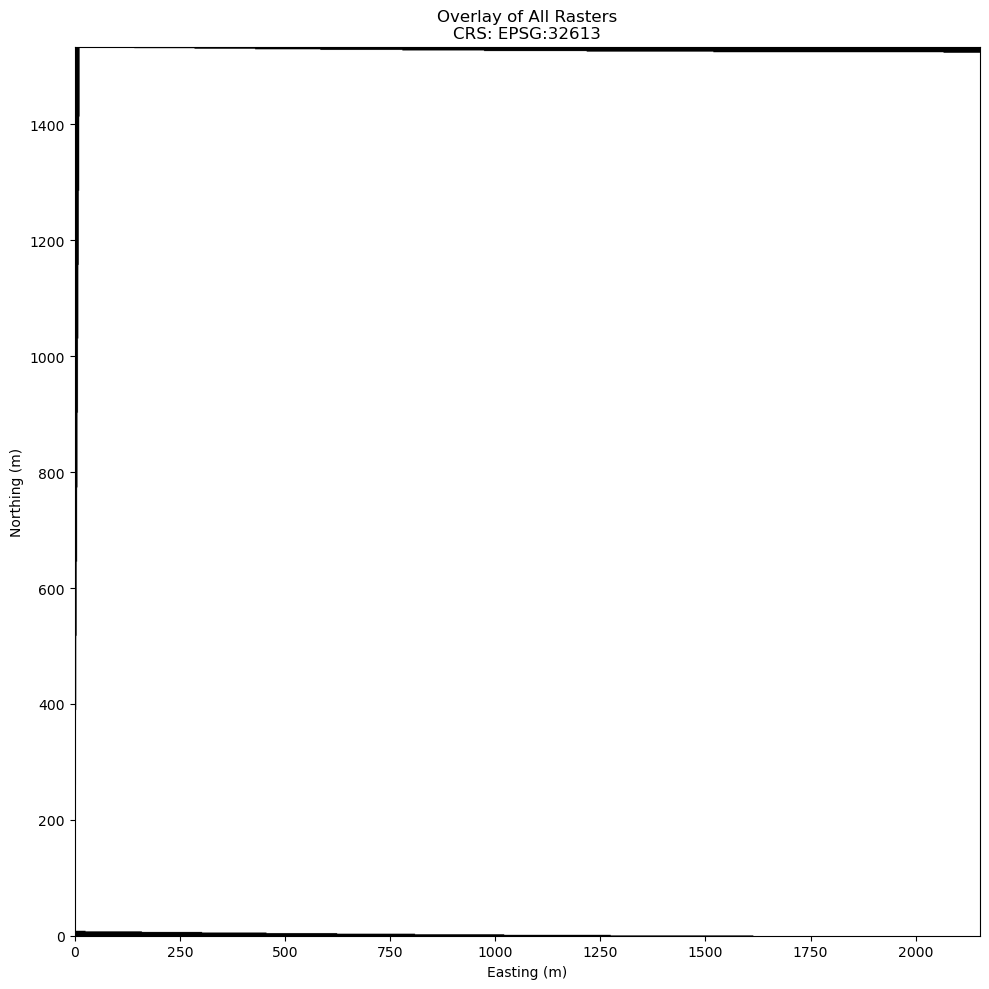

In [ ]:
import os
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import rasterio.crs as crs
from rasterio.warp import calculate_default_transform, reproject, Resampling

# Define file names
files = [
    "boulder_soil_reclassified_utm.tif",
    "linearwater_buffer_utm13N100M.tif",
    "boulder_precipitation_utm13.tif",
    "north_east_west_south_slopes.tif",
    "highlighted_elevation_ranges_utm13n.tif"
]

# Number of rows and columns in the grid
n_cols = 3
n_rows = -(-len(files) // n_cols)  # Ceiling division to determine rows

# Create a figure and axes
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.ravel()  # Flatten axes for easy indexing

# Harmonize all rasters to the same CRS and spatial extent
def reproject_to_common_crs(src, common_crs, common_transform, common_width, common_height):
    dest = np.zeros((common_height, common_width), dtype=src.read(1).dtype)
    reproject(
        source=rasterio.band(src, 1),
        destination=dest,
        src_transform=src.transform,
        src_crs=src.crs,
        dst_transform=common_transform,
        dst_crs=common_crs,
        resampling=Resampling.nearest
    )
    return dest

# Determine the common CRS and spatial extent
common_crs = "EPSG:32613"  # UTM Zone 13N
common_transform = None
common_width, common_height = None, None

with rasterio.open(files[0]) as ref_src:
    common_transform, common_width, common_height = calculate_default_transform(
        ref_src.crs, common_crs, ref_src.width, ref_src.height, *ref_src.bounds
    )

# Loop through each file and display it
harmonized_data = []
for i, file in enumerate(files):
    try:
        with rasterio.open(file) as src:
            # Reproject to common CRS and extent
            reprojected_data = reproject_to_common_crs(src, common_crs, common_transform, common_width, common_height)

            # Mask invalid data (e.g., no-data values)
            reprojected_data = np.ma.masked_equal(reprojected_data, src.nodata)

            # Scale data to range 0 to 1
            data_min = reprojected_data.min()
            data_max = reprojected_data.max()
            scaled_data = (reprojected_data - data_min) / (data_max - data_min)

            # Store harmonized data for overlay
            harmonized_data.append(scaled_data)

            # Display the raster on the corresponding subplot
            axes[i].imshow(scaled_data, cmap='gray', extent=(0, common_width, 0, common_height), aspect='auto')

            # Set the title with CRS information
            crs_info = src.crs.to_string() if src.crs else "Unknown CRS"
            axes[i].set_title(f"{os.path.basename(file)}\nCRS: {crs_info}")

            # Set UTM Zone 13N axes
            axes[i].set_xlabel("Easting (m)")
            axes[i].set_ylabel("Northing (m)")
    except Exception as e:
        # If there's an error, show it in the plot title
        axes[i].text(0.5, 0.5, f"Error\n{e}", fontsize=10, ha='center', transform=axes[i].transAxes)
        axes[i].set_title(os.path.basename(file))
        axes[i].axis('off')

# Turn off any unused axes
for j in range(len(files), len(axes)):
    axes[j].axis('off')

# Overlay all harmonized data on a separate plot
fig_overlay, ax_overlay = plt.subplots(figsize=(10, 10))
combined_data = np.sum(harmonized_data, axis=0)
ax_overlay.imshow(combined_data, cmap='gray', extent=(0, common_width, 0, common_height), aspect='auto')
ax_overlay.set_title("Overlay of All Rasters\nCRS: EPSG:32613")
ax_overlay.set_xlabel("Easting (m)")
ax_overlay.set_ylabel("Northing (m)")

plt.tight_layout()
plt.show()


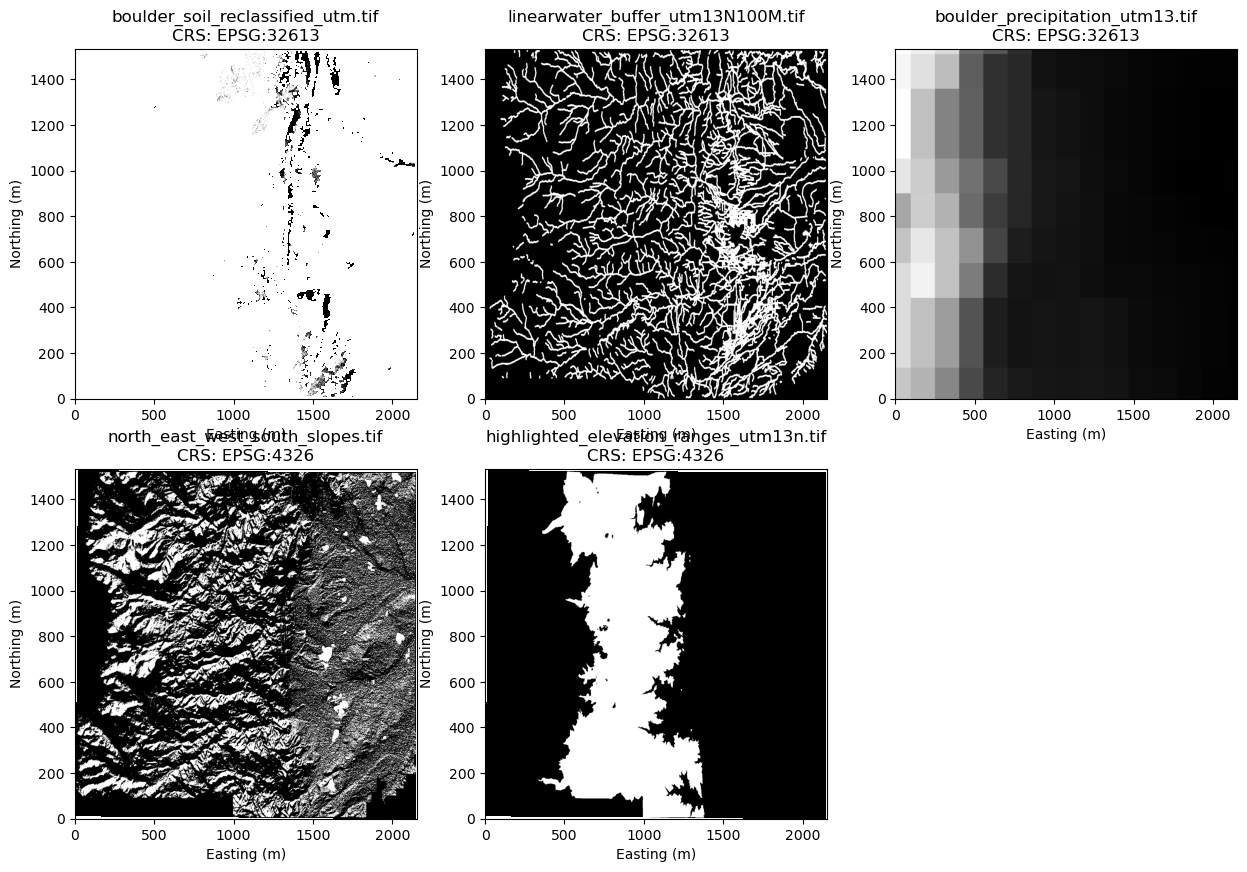

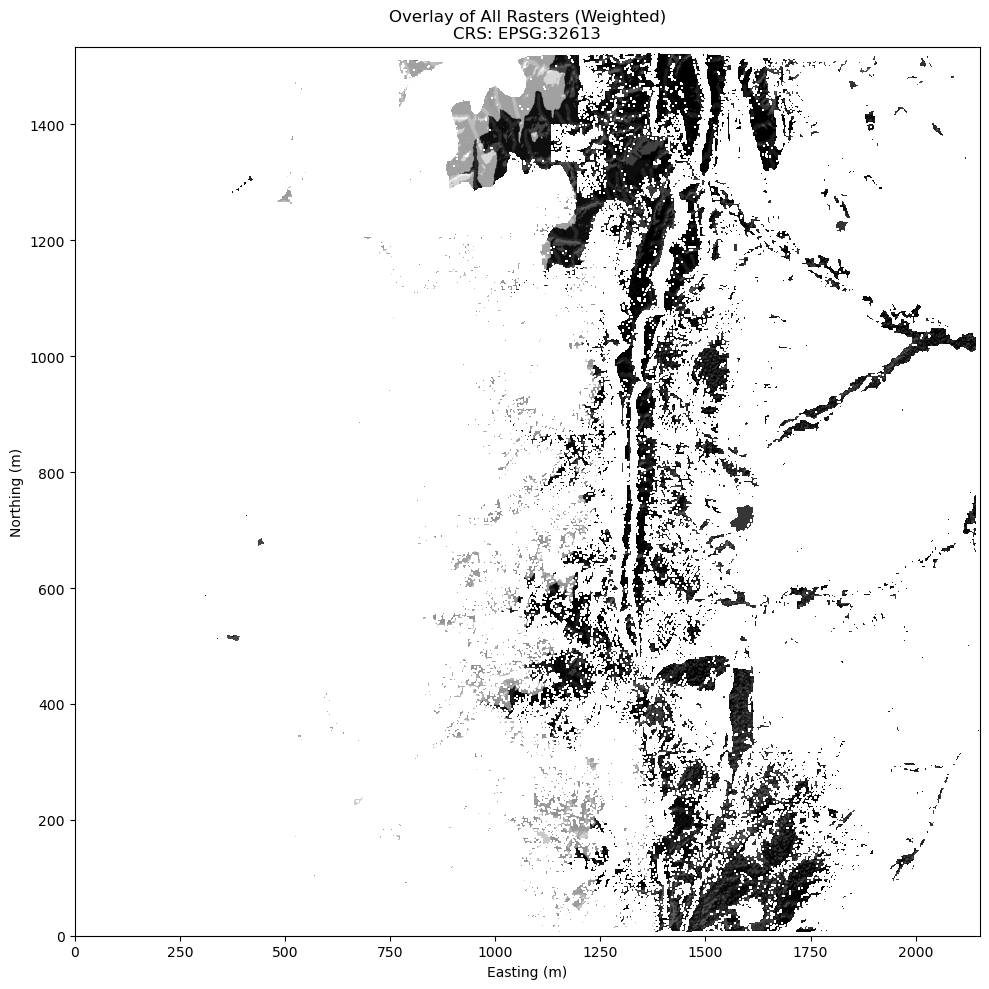

In [16]:
import os
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import rasterio.crs as crs
from rasterio.warp import calculate_default_transform, reproject, Resampling

# Define file names and their corresponding weights
files = [
    "boulder_soil_reclassified_utm.tif",
    "linearwater_buffer_utm13N100M.tif",
    "boulder_precipitation_utm13.tif",
    "north_east_west_south_slopes.tif",
    "highlighted_elevation_ranges_utm13n.tif"
]

weights = [
    0.05,  # for boulder_soil_reclassified_utm.tif
    0.1,  # for linearwater_buffer_utm13N100M.tif
    0.1,  # for boulder_precipitation_utm13.tif
    0.2,  # for north_east_west_south_slopes.tif
    0.55   # for highlighted_elevation_ranges_utm13n.tif (no weight)
]

# Number of rows and columns in the grid
n_cols = 3
n_rows = -(-len(files) // n_cols)  # Ceiling division to determine rows

# Create a figure and axes
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
axes = axes.ravel()  # Flatten axes for easy indexing

# Harmonize all rasters to the same CRS and spatial extent
def reproject_to_common_crs(src, common_crs, common_transform, common_width, common_height):
    dest = np.zeros((common_height, common_width), dtype=src.read(1).dtype)
    reproject(
        source=rasterio.band(src, 1),
        destination=dest,
        src_transform=src.transform,
        src_crs=src.crs,
        dst_transform=common_transform,
        dst_crs=common_crs,
        resampling=Resampling.nearest
    )
    return dest

# Determine the common CRS and spatial extent
common_crs = "EPSG:32613"  # UTM Zone 13N
common_transform = None
common_width, common_height = None, None

with rasterio.open(files[0]) as ref_src:
    common_transform, common_width, common_height = calculate_default_transform(
        ref_src.crs, common_crs, ref_src.width, ref_src.height, *ref_src.bounds
    )

# Loop through each file and display it
harmonized_data = []
for i, file in enumerate(files):
    try:
        with rasterio.open(file) as src:
            # Reproject to common CRS and extent
            reprojected_data = reproject_to_common_crs(src, common_crs, common_transform, common_width, common_height)

            # Mask invalid data (e.g., no-data values)
            reprojected_data = np.ma.masked_equal(reprojected_data, src.nodata)

            # Scale data to range 0 to 1
            data_min = reprojected_data.min()
            data_max = reprojected_data.max()
            scaled_data = (reprojected_data - data_min) / (data_max - data_min)

            # Store harmonized data for overlay
            harmonized_data.append(scaled_data)

            # Display the raster on the corresponding subplot
            axes[i].imshow(scaled_data, cmap='gray', extent=(0, common_width, 0, common_height), aspect='auto')

            # Set the title with CRS information
            crs_info = src.crs.to_string() if src.crs else "Unknown CRS"
            axes[i].set_title(f"{os.path.basename(file)}\nCRS: {crs_info}")

            # Set UTM Zone 13N axes
            axes[i].set_xlabel("Easting (m)")
            axes[i].set_ylabel("Northing (m)")
    except Exception as e:
        # If there's an error, show it in the plot title
        axes[i].text(0.5, 0.5, f"Error\n{e}", fontsize=10, ha='center', transform=axes[i].transAxes)
        axes[i].set_title(os.path.basename(file))
        axes[i].axis('off')

# Turn off any unused axes
for j in range(len(files), len(axes)):
    axes[j].axis('off')

# Overlay all harmonized data with the weights
fig_overlay, ax_overlay = plt.subplots(figsize=(10, 10))

# Weighted sum of the rasters
combined_data = np.zeros_like(harmonized_data[0])  # Initialize with the same shape as the first raster
for i, data in enumerate(harmonized_data):
    combined_data += data * weights[i]  # Multiply each raster by its weight

# Normalize the combined data to be in the range [0, 1]
combined_data_min = combined_data.min()
combined_data_max = combined_data.max()
combined_data = (combined_data - combined_data_min) / (combined_data_max - combined_data_min)

# Display the combined weighted raster
ax_overlay.imshow(combined_data, cmap='gray', extent=(0, common_width, 0, common_height), aspect='auto')
ax_overlay.set_title("Overlay of All Rasters (Weighted)\nCRS: EPSG:32613")
ax_overlay.set_xlabel("Easting (m)")
ax_overlay.set_ylabel("Northing (m)")

plt.tight_layout()
plt.show()
